In [2]:
#Importing necessary libraries 
from tensorflow import keras
import numpy as np
import pandas as pd
from keras.applications import resnet
#from tensorflow.keras.applications import Resnet50
#from keras.applications.resnet50 import ResNet50
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint

In [3]:
# Load the ResNet50 model
resnet_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [4]:
# checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f437ac4f390> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f440169e990> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f436efabe10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f436e5c4390> True
<keras.layers.core.activation.Activation object at 0x7f436e5e3f50> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f436c18f950> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f436c19cd90> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f436c196ed0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f436e5a4f10> True
<keras.layers.core.activation.Activation object at 0x7f4418223790> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f436f169810> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f436c1b7190> True
<keras.layers.core.activati

In [5]:
# Adding classifier on top of Convolution model
# create model 
model = models.Sequential()

In [6]:
# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [7]:
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
dataset_url = r'/kaggle/input/eurosat-rgb/2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255
     

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True,
         validation_split=0.2)

In [10]:
train_set = train_datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')
     

Found 21600 images belonging to 10 classes.


In [11]:
#Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [12]:
test_set = test_datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=False,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')
     

Found 5400 images belonging to 10 classes.


In [13]:
# lets dettermine dataset characteristics
print('Training Data: ',train_set[0][0].shape)
print('Test Data: ',test_set[0][0].shape)

Training Data:  (32, 64, 64, 3)
Test Data:  (32, 64, 64, 3)


In [14]:
# now shape of a single image
print('Shape of single image:', train_set[0][0][0].shape)

Shape of single image: (64, 64, 3)


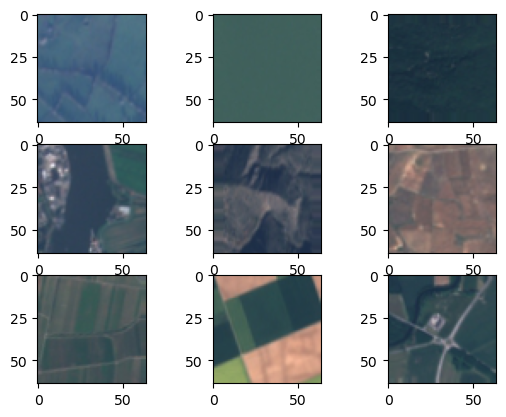

In [15]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = train_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
     

In [17]:
# checkpoint
filepath="/kaggle/working//weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
# Train the model
history = model.fit(
          train_set, 
         steps_per_epoch=(train_set.samples/32),
          epochs=3,
          callbacks=callbacks_list,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/3
675/675 [==============================] - ETA: 0s - loss: 0.5473 - acc: 0.8695
Epoch 1: val_acc improved from -inf to 0.12222, saving model to /kaggle/working/weights.best.hdf5
675/675 [==============================] - 151s 199ms/step - loss: 0.5473 - acc: 0.8695 - val_loss: 32.1937 - val_acc: 0.1222
Epoch 2/3
675/675 [==============================] - ETA: 0s - loss: 0.3353 - acc: 0.9333
Epoch 2: val_acc improved from 0.12222 to 0.95315, saving model to /kaggle/working/weights.best.hdf5
675/675 [==============================] - 66s 98ms/step - loss: 0.3353 - acc: 0.9333 - val_loss: 0.9606 - val_acc: 0.9531
Epoch 3/3
675/675 [==============================] - ETA: 0s - loss: 0.3177 - acc: 0.9449
Epoch 3: val_acc did not improve from 0.95315
675/675 [==============================] - 65s 96ms/step - loss: 0.3177 - acc: 0.9449 - val_loss: 1.8019 - val_acc: 0.8869


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


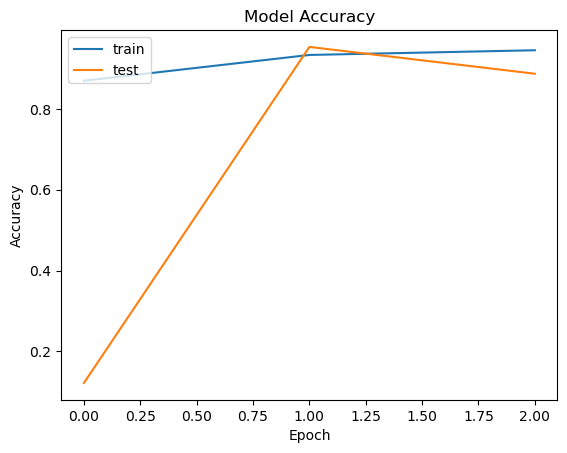

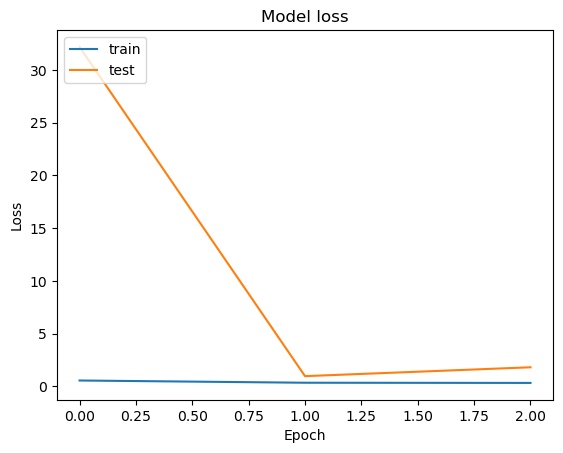

In [19]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
     

In [20]:
# loading the weights with ~97% acc
from keras.models import load_model
model = load_model('/kaggle/working/weights.best.hdf5')

In [21]:
# Visualizing the mapping of labels
test_set.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [22]:
# Confusion Matrix and Classification report
# creating 
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential" ,"River", "SeaLake"])
print(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
                      AnnualCrop  Forest  HerbaceousVegetation  Highway  \
AnnualCrop                   542       1                     6        1   
Forest                         0     594                     4        0   
HerbaceousVegetation           0       1                   589        0   
Highway                        3       0                     2      474   
Industrial                     0       0                     4        0   
Pasture                        3       2                    15        1   
PermanentCrop                  4       0                    35        0   
Residential                    0       0                     0        0   
River                          4       0                     0        8   
SeaLake                        3       2                     0        0   

                      Industrial  Pasture  PermanentCrop  Residential  River  \
AnnualCrop                     0        8             39            0      0 

In [23]:
print('Classification Report')
target_names = ['AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway',"Industrial", 'Pasture', 'PermanentCrop','Residential', 'River', 'SeaLake']
classifcn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classifcn_report)

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.90      0.94       600
              Forest       0.99      0.99      0.99       600
HerbaceousVegetation       0.90      0.98      0.94       600
             Highway       0.98      0.95      0.96       500
          Industrial       0.99      0.90      0.95       500
             Pasture       0.95      0.92      0.93       400
       PermanentCrop       0.89      0.91      0.90       500
         Residential       0.92      1.00      0.96       600
               River       0.97      0.96      0.97       500
             SeaLake       0.98      0.98      0.98       600

            accuracy                           0.95      5400
           macro avg       0.95      0.95      0.95      5400
        weighted avg       0.95      0.95      0.95      5400



In [110]:
class_names = list(test_set.class_indices.keys())
predictions = model.predict(test_set, steps=1)
filenames = test_set.filenames
predicted_class_indices = np.argmax(predictions,axis=1)
classnames = []
for i in range(20):
    #classnames.append(class_names[predicted_class_indices.item(i)])
    print(f"Actual: {filenames[i]},\n Predicted:{class_names[predicted_class_indices.item(i)]}")
    
# results = pd.DataFrame({"Filename":filenames,
#                       "Prediction":classnames})
#results.head(10)
 

1/1 [==============================] - 0s 71ms/step
Actual: AnnualCrop/AnnualCrop_1.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_10.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_100.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1000.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1001.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1002.jpg,
 Predicted:PermanentCrop
Actual: AnnualCrop/AnnualCrop_1003.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1004.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1005.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1006.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1007.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1008.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1009.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_101.jpg,
 Predicted:AnnualCrop
Actual: AnnualCrop/AnnualCrop_1010.jpg,
 Predicted:PermanentCrop
Actual: AnnualCrop/